<a href="https://colab.research.google.com/github/talisainen/ICM0031-data-analysis/blob/main/homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esimene koduetöö aines ICM0031, "Andmeanalüüs"


### Aleksei Talisainen, 225287IAXD


---



Check if Pandas in installed, otherwise ```pip install pandas```

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, shapiro, kstest, ttest_rel, pearsonr

# 1. Data preparation

Import csv file and transform its content into a dataframe

In [103]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/ICM0031-course-data-analysis/Uuring2012.csv')
# df.head() # uncomment to display the first 5 lines of the dataframe

# the following code should be used to upload the data from a file manually without accessing Google Drive
# from google.colab import files
# uuring_excel = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> **Importige sellest failist 1000 andmerida;**

This code will check the dimension of the dataframe, remove the entries after line 1000 and return the updated dimensions.

```inplace``` parameter means that no additional object is created, the existing one is modified instead. That is done for memory saving purposes in case the amount of data is large.

In [104]:
# print(f'Initial dimensions of the dataframe are {df.shape}')
df.drop(df.index[1000:], inplace=True)
# print(f'New dimensions are {df.shape}')

The first column ('jrk') represents a serial number and can be removed

In [105]:
if 'jrk' in df.columns:
  df.drop(columns=['jrk'], inplace=True)
else:
  print('Column already deleted')

Check if any dataframe columns contain NaN cells and output the results.

P.S. for a certainty double-checked with Excel _countblank_ function.

In [106]:
for column in df:
  contains_nan = df[column].isna().any()
  if contains_nan:
    print(f'Contains NaN values: {column}')
  # else:
  #   print(f'Does not contain NaN values: {column}')

Contains NaN values: Sec
Contains NaN values: T_seis
Contains NaN values: T_tunde


According to the metadata
- ```Sec``` column has an ```undefined``` (määramata) option with a value "99",
- ```T_seis``` has an ```undefined``` (määramata) option with a value "9",
- ```T_tunde``` has an ```undefined``` (määramata) option with a value "9"

__It is justified to replace NaN with the value of an "undefined" parameter__

In [107]:
df['Sec'] = df['Sec'].fillna(99)
df['T_seis'] = df['Sec'].fillna(9)
df['T_tunde'] = df['Sec'].fillna(9)

# 2. Diagrams
> **koostage vähemalt üks tulp- ja vähemalt üks sektordiagramm, mis peegeldavad küsitlusele vastanute vanuselist koostist ja päritolu (Põhja-Eesti, Kesk-Eesti, ...)**

To do so it is necessary to map the numerical values in the corresponding columns: age (vanus) and place of birth (päritolu).

I will create a copy of the dataframe to leave the original one unchanged and replace the numbers with string values.

In [108]:
df_strings = df.copy()

In [109]:
print(df_strings.columns)

Index(['Sugu', 'vanusegrupp', 'Tper_seis', 'Rahvus', 'Haridus', 'Sec',
       'T_seis', 'T_tunde', 'Lk_pk', 'Hh_s1', 'V01C', 'V02C', 'V03C', 'V27C',
       'V30C', 'V34C', 'V36C', 'V37C', 'V38C', 'V41C', 'V42C', 'V45C', 'V46C',
       'V49C', 'V50C'],
      dtype='object')


According to the metadata "vanusegroup" value '99' corresponds to "määramata" (undefined), value '99' will be replaced with 'määramata'

In [110]:
df_strings['vanusegrupp'] = df_strings['vanusegrupp'].replace('99', 'määramata')

## Age distribution pie chart

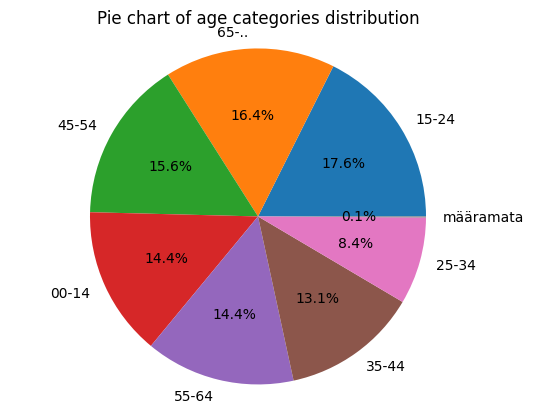

In [10]:
# drawing a pie chart
category_counts = df_strings['vanusegrupp'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Pie chart of age categories distribution')
plt.axis('equal')
plt.show()

Place of birth (_päritolu_) is coded using numbers 1-5, it is required to map the numeric values with regions in ```Lk_pk``` column in accordance with the metadata:
- 1 with "Põhja-Eesti"
- 2 with "Kesk-Eesti"
- 3 with "Kirde-Eesti"
- 4 with "Lääne-Eesti"
- 5 with "Lõuna-Eesti"
- 9 with "määramata"


## Population distribution historamm

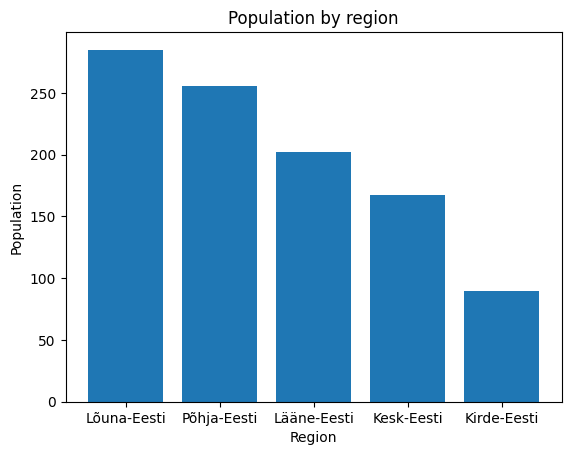

In [11]:
# Create a dictionary with region names
Lk_pk_labels = {1:"Põhja-Eesti", 2:"Kesk-Eesti", 3: "Kirde-Eesti", 4:"Lääne-Eesti", 5:"Lõuna-Eesti", 9:"määramata"}

#map region codes to region names
df_strings['Lk_pk'] = df['Lk_pk'].map(Lk_pk_labels)

category_counts = df_strings['Lk_pk'].value_counts()
plt.bar(category_counts.index, category_counts)
plt.title('Population by region')
plt.xlabel('Region')
plt.ylabel('Population')
plt.show()

# 3. Statistical analysis
> **Leidke punkthinnangud leibkondade väljaminekute ja tarbimiskulutuste kohta:**

I will create a copy of the dataframe for manipulations

In [111]:
df_stat = df.copy()

Values in columns 'V01C',	'V02C',	'V03C',	'V27C',	'V30C',	'V34C',	'V36C',	'V37C',	'V38C',	'V41C',	'V42C',	'V45C',	'V46C',	'V49C',	'V50C' should be of type ```float```, but they are interpreted as ```string``` because comma is used instead of a dot.

Function ```convert_to_float``` replaces commas with a dots and attempts to convert the result to float. In case such conversion is impossible the initial value is returned.

In [112]:
print(df_stat.head(5))

   Sugu vanusegrupp  Tper_seis  Rahvus  Haridus   Sec  T_seis  T_tunde  Lk_pk  \
0     1       35-44          2       1        2  11.0    11.0     11.0      5   
1     2       45-54          2       1        2  11.0    11.0     11.0      2   
2     2       00-14          1       1        9  99.0    99.0     99.0      5   
3     1       15-24          2       1        1  11.0    11.0     11.0      5   
4     1       35-44          1       2        1  11.0    11.0     11.0      3   

   Hh_s1  ...       V34C       V36C       V37C       V38C      V41C  \
0      5  ...    275,172  140,78008  246,01782    77,4912  197,6256   
1      2  ...  797,61902          0          0          0  256,7124   
2      5  ...  188,33921          0          0          0   54,0857   
3      5  ...  530,83611  145,00552          0  735,91228  224,7984   
4      3  ...   672,6048  189,96903          0  156,72683   112,336   

        V42C       V45C      V46C       V49C V50C  
0  283,92187          0         0 

The data in some cells is stored in a wrong format that cannot be correctly interpreted, examples are "1,12,7712" and "1,11,2581".

Such values are sparse and removing the lines is unreasonable, these values are replaced with NaN.

_P. S. This code can be added into the cycle from the previous cell to save time_

In [113]:
def convert_to_float(value):
  '''this function converts string values into floating point numbers if the string is in appropriate format'''
  if isinstance(value, str):
    try:
      return float(value.replace(',', '.'))
    except ValueError:
      print(f'This value could not be interpreted: {value}')
      return value
  return value  # Leave existing float values unchanged


columns = ['V01C', 'V02C', 'V03C', 'V27C', 'V30C', 'V34C', 'V36C', 'V37C', 'V38C', 'V41C', 'V42C', 'V45C', 'V46C', 'V49C', 'V50C']

for column in columns:
  df_stat[column] = df[column].apply(convert_to_float) # calls a conversion function for each column
  df_stat[column] = pd.to_numeric(df_stat[column], errors='coerce')
  df_stat[column].isna().sum()

This value could not be interpreted: 1,06,3829
This value could not be interpreted: 1,12,7309
This value could not be interpreted: 1,06,5564
This value could not be interpreted: 1,12,8224
This value could not be interpreted: 1,12,7413
This value could not be interpreted: 1,08,6066
This value could not be interpreted: 1,09,9876
This value could not be interpreted: 1,10,3451
This value could not be interpreted: 1,07,5456
This value could not be interpreted: 1,06,2619
This value could not be interpreted: 1,04,9634
This value could not be interpreted: 1,12,7738
This value could not be interpreted: 1,06,7871
This value could not be interpreted: 1,04,2407
This value could not be interpreted: 1,04,2874
This value could not be interpreted: 1,12,7738
This value could not be interpreted: 1,09,3913
This value could not be interpreted: 1,08,3921
This value could not be interpreted: 1,02,5441
This value could not be interpreted: 1,02,9443
This value could not be interpreted: 1,05,2572
This value co

## Calculating mean, median, standard deviation, and quartiles
> **Leidke punkthinnangud leibkondade väljaminekute ja tarbimiskulutuste kohta:\
a) aritmeetiline keskmine,\
b) mediaan,\
c) alumine ja ülemine kvartiil,\
d) standardhälve,\
e) kvartiilide vahe**

I will construct a dataseries for each column from ```columns``` containing the values from ```indexes``` and create a list with indexes for the following parameters: "mean", "median", "first_quartile", "third_quartile", "std_dev", and "iqr" (stands for interquartile range).

In [114]:
indexes = ["Mean value", "Median value", "First quartile", "Third quartile", "Standard deviation", "IQR"]
columns = ['V01C', 'V02C', 'V03C', 'V27C', 'V30C', 'V34C', 'V36C', 'V37C', 'V38C', 'V41C', 'V42C', 'V45C', 'V46C', 'V49C', 'V50C']

for column in columns:
  dataSeries_name = f'ds_{column}'
  mean = df_stat[column].mean()
  median = df_stat[column].median()
  first_quartile = df_stat[column].quantile(0.25)
  third_quartile = df_stat[column].quantile(0.75)
  std_dev = df_stat[column].std()
  iqr = third_quartile - first_quartile
  dataSeries_name = pd.Series([mean, median, first_quartile, third_quartile, std_dev, iqr], index = indexes, name = column)
  print(dataSeries_name)

Mean value            3138.415147
Median value          2710.730830
First quartile        1660.987105
Third quartile        3963.104235
Standard deviation    2116.356382
IQR                   2302.117130
Name: V01C, dtype: float64
Mean value            3096.467194
Median value          2648.339475
First quartile        1651.006855
Third quartile        3894.925758
Standard deviation    2072.646427
IQR                   2243.918903
Name: V02C, dtype: float64
Mean value             907.964445
Median value           825.046855
First quartile         540.431555
Third quartile        1195.245432
Standard deviation     514.921738
IQR                    654.813877
Name: V03C, dtype: float64
Mean value            133.539500
Median value           42.237185
First quartile          0.000000
Third quartile        163.709275
Standard deviation    230.009217
IQR                   163.709275
Name: V27C, dtype: float64
Mean value            147.728420
Median value            5.601950
First quartile  

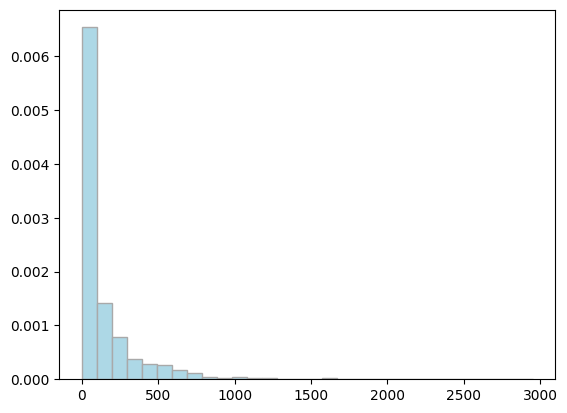

In [115]:
#assigning the output to a variable ```-``` supresses raw data output and draws the plot only
_ = plt.hist(df_stat['V27C'], bins=30, density=True, color='lightblue', edgecolor='darkgray', label='Data')


# 4. Analyze the results using boxplot
 > **illustreerige toidukulusid karpdiagrammi (boxplot) abil. Kommenteerige joonist!**

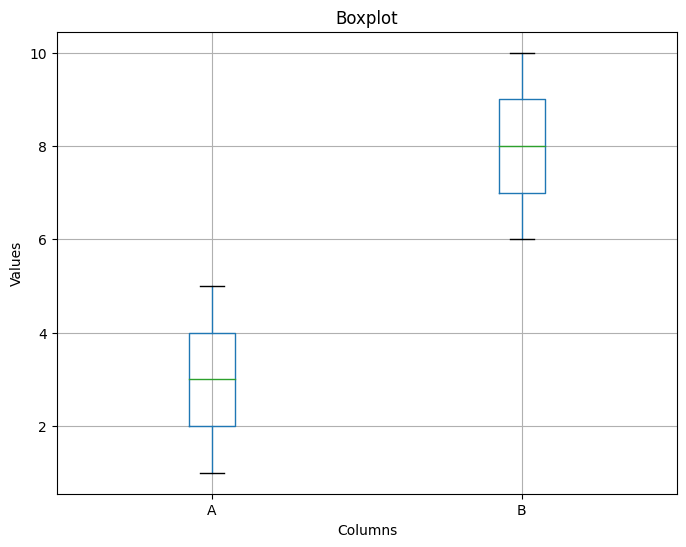

In [95]:
# Example DataFrame
data = {'A': [1, 2, 3, 4, 5],
        'B': [6, 7, 8, 9, 10]}
df = pd.DataFrame(data)

# Draw a boxplot using Matplotlib
plt.figure(figsize=(8, 6))  # Optional: set the size of the plot
df.boxplot()
plt.title('Boxplot')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()

# 5. Calculations using confidence level
> **Leidke 95%-lise usaldusnivooga usalduspiirid transpordikulude keskmise ja standardhälbe kohta**

Transportation expenses are listed in category **V38C**
First I will calculate common statistical values using ```describe``` method.

In [32]:
df_stat['V38C'].describe()

count     999.000000
mean      415.421528
std       778.787311
min         0.000000
25%         0.000000
50%       105.876340
75%       522.546465
max      8003.102870
Name: V38C, dtype: float64

The sample size is limited to 1000 samples, the population is infinite.



In [33]:
confidence_level = 0.95
data = df_stat['V38C'].dropna()
mean_value = (data.mean())
sample_size = len(data)
stdev = data.std()
z = norm.ppf((1 + confidence_level) / 2) # critical value
standard_error = stdev / np.sqrt(sample_size)
error_margin = z * standard_error
confidence_interval = (mean_value - error_margin, mean_value + error_margin)
print(f'95% confidence interval is {confidence_interval} and error margin is approximately {error_margin:.4f}')

95% confidence interval is (367.12852484084306, 463.7145312352329) and error margin is approximately 48.2930


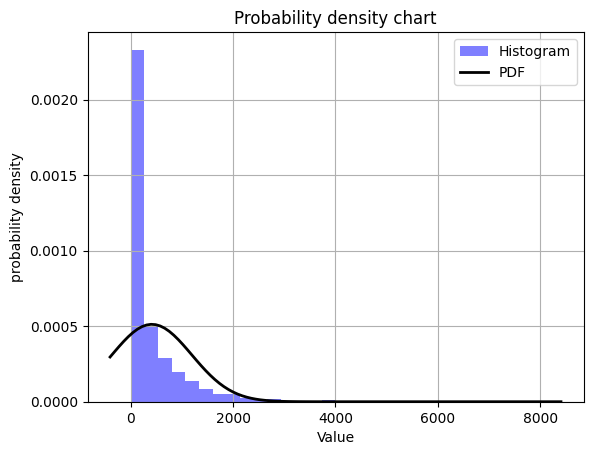

In [35]:
# TEST

import numpy as np
import matplotlib.pyplot as plt

data = df_stat['V38C'].dropna()

# Plotting the probability density
plt.hist(data, bins=30, density=True, color='blue', alpha=0.5, label='Histogram')  # Distribution histogram
plt.xlabel('Value')
plt.ylabel('probability density')

# Calculating the probability density for a normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(data), np.std(data))
plt.plot(x, p, 'k', linewidth=2, label='PDF')  # График плотности вероятности, probability density function

plt.title('Probability density chart')
plt.legend()
plt.grid(True)

# Chart display
plt.show()


# 6. Hypotheses testing
> **Uurige hüpoteese, kontrollides (riskinivool 5%), kas leibkondade väljaminekud on normaaljaotusega. Või, kas nad on eksponentjaotusega. Sõnastage hüpoteesid ja põhjendage otsus. Illustreerige joonise abil. Lisage joonisele oma kommentaar**

I will use [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) to validate whether the data has exponential distribution and [Shapiro–Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) to validate normal distribution.

In [21]:
data = df_stat['V01C'].dropna()
alpha = 0.05 # 5% riskinivoo
stat_shapiro, p_shapiro = shapiro(data)
stat_kolmogorov, p_kolmogorov = kstest(data, 'expon')

if p_shapiro > alpha:
  print('The data is normally distributed with 5% significance level')
if stat_kolmogorov > alpha:
  print('The data is exponentially distributed with 5% significance level')
else:
  print('The data does not follow normal or exponential distribution')

The data is exponentially distributed with 5% significance level


I will draw a histogram of the data and add Gauss and exponential approximation to illustrate the result above.

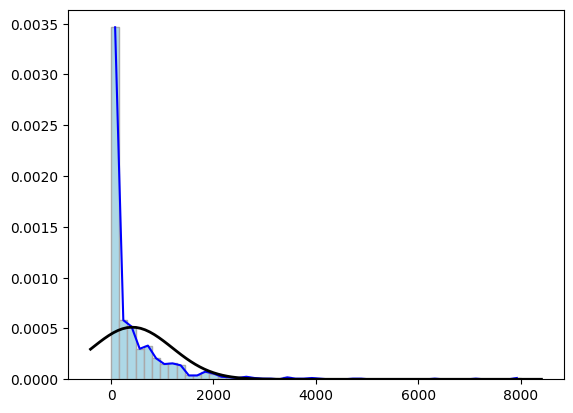

In [41]:
# drawing data histogramm
hist, bin_edges = np.histogram(data, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
_ = plt.hist(data, bins=50, density=True, color='lightblue', edgecolor='darkgray', label='Data')

# drawing data chart
plt.plot(bin_centers, hist, '-', color='blue', label='Data')

# drawing normal distribution chart
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
normal_distribution = norm.pdf(x, np.mean(data), np.std(data))
_ = plt.plot(x, p, 'k', linewidth=2, label='Normal PDF')

# # drawing exponential distribution chart
# exponential_distribution = expon.pdf(data, scale=1)
# plt.plot(x, exponential_distribution, 'r-', label='Exponential PDF')
# plt.legend()

# 7. t-test
**Võrrelge 5%-lise eksimisriskiga Lääne-Eesti ja Põhja-Eesti keskmisi eluasemekulusid (on need võrdsed? on Põhja-Eestis suuremad? on Lääne-Eestis suuremad?) Kommenteerige tulemust!**

To compare the values I can use t-test, but the question is whether the values are dependent or not. As country budget is common, both areas share the same geographical location, and have similar economics I will assume that the expences change according to the same factors, therefore I will use paired t-test.

I will filter the dataframe to remove all regions, except "1" (Põhja-Eesti) and "4" (Lääne-Eesti) and separate them.

In [88]:
df_filtered = df_stat[df_stat['Lk_pk'].isin([1, 4])]
pohjaEesti_data = df_filtered[df_filtered['Lk_pk'] == 1]
lounaEesti_data = df_filtered[df_filtered['Lk_pk'] == 4]

I need to make sure that the dataframes have same dimensions (although I know they are)

In [89]:
min_length = min(len(pohjaEesti_data), len(lounaEesti_data))
pohjaEesti_data = pohjaEesti_data.iloc[:min_length]
lounaEesti_data = lounaEesti_data.iloc[:min_length]

Now I will perform a paired t-test

In [90]:
t_stat, p_value = ttest_rel(pohjaEesti_data['V34C'], lounaEesti_data['V34C'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Rejects the null hypothesis: There is a significant difference between the values for regions 1 and 2.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the values for regions 1 and 2.")

T-statistic: 4.956487267086761, P-value: 1.5215668806925925e-06
Rejects the null hypothesis: There is a significant difference between the values for regions 1 and 2.


To compare values I will use ```describe``` method as the simplest one.

In [91]:
pohjaEesti_data['V34C'].describe()

count     202.000000
mean      685.600943
std       500.661647
min         0.000000
25%       356.753902
50%       563.726200
75%       812.841825
max      2810.893400
Name: V34C, dtype: float64

In [92]:
lounaEesti_data['V34C'].describe()

count     202.000000
mean      460.226247
std       388.712560
min         0.000000
25%       216.515842
50%       354.604135
75%       557.400168
max      2412.410290
Name: V34C, dtype: float64

Apparently, Põhja-Eesti inhabitants spend substantially more in "Eluase" category expenses.


# 8. Calculation dispersion
> **Kas kulutused tervishoiule varieeruvad haridusgruppide lõikes samapalju või erinevalt (võrrelge dispersioone/standardhälbeid). Riskinivooks võtke 5%.**

Dispersion for Haridus 2: 235.38255074937305
Dispersion for Haridus 9: 98.32358734807642
Dispersion for Haridus 1: 120.69165640400945
Dispersion for Haridus 3: 264.80173479230086


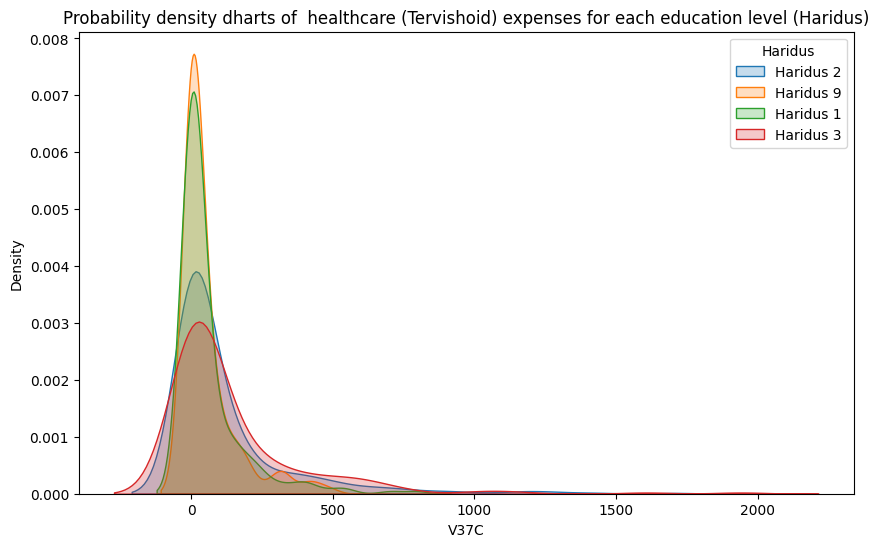

In [119]:
# Filter data for each value in Haridus
# haridus_values = df_stat['Haridus'].unique()

# Calculate dispersion (standard deviation in this case)
dispersion = {value: data.std() for value, data in data_groups.items()}

for value, disp in dispersion.items():
    print(f'Dispersion for Haridus {value}: {disp}')

# Plot probability density charts
plt.figure(figsize=(10, 6))

# Create legend
for value, data in data_groups.items():
    sns.kdeplot(data, label=f'Haridus {value}', fill=True)

plt.title('Probability density dharts of  healthcare (Tervishoid) expenses for each education level (Haridus)')
plt.xlabel('V37C')
plt.ylabel('Density')
plt.legend(title='Haridus')
plt.show()

I will change the limits of the chart for better visibility

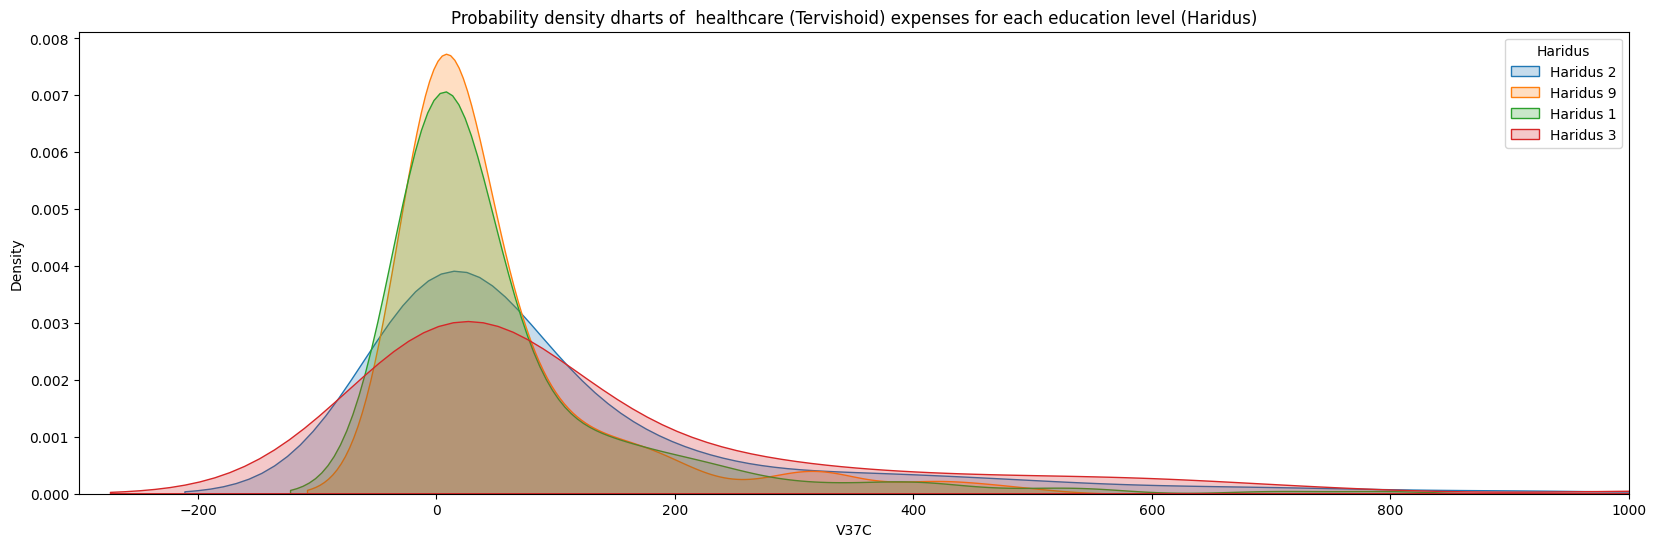

In [86]:
plt.figure(figsize=(20, 6))

for value, data in data_groups.items():
    sns.kdeplot(data, label=f'Haridus {value}', fill=True)

plt.title('Probability density dharts of  healthcare (Tervishoid) expenses for each education level (Haridus)')
plt.xlabel('V37C')
plt.ylabel('Density')
plt.legend(title='Haridus')
plt.xlim(-300, 1000)
plt.show()

Although it is apparent from the chart, I will investigate if ehre is a statistical difference between the groups using ANOVA

In [87]:
from scipy.stats import f_oneway

data_for_anova = [data for data in data_groups.values()]
f_statistic, p_value = f_oneway(*data_for_anova)

print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Check significance
if p_value < 0.05:
    print("There is a statistically significant difference between the groups (p < 0.05).")
else:
    print("There is no statistically significant difference between the groups (p >= 0.05).")


F-statistic: 9.78173048099999
P-value: 2.3111207778506062e-06
There is a statistically significant difference between the groups (p < 0.05).


# 9. Correlation with confidence
> **Uurige, kas 95%-lise usaldusnivooga võib väita korrelatiivse sõltuvuse olemasolu kõikide väljaminekute ja eluasemekulude vahel?**

I will use Pearson coefficient to calculate correlation

In [94]:
correlation_coefficient, p_value = pearsonr(df_stat['V01C'], df_stat['V34C'])

print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

# Checking if the correlation is significant at the 95% confidence level
alpha = 0.05  # 95% confidence level
if p_value < 0.05:
    print("There is a significant correlation between V01C and V34C.")
else:
    print("There is no significant correlation between V01C and V34C.")


Pearson correlation coefficient: 0.4231005225950774
P-value: 1.0650723179700646e-44
There is a significant correlation between V01C and V34C.


## Rikkad inimesed, kellel on "Muud kulutused"

In [120]:
rikkad = (df_stat['V50C'] != 0).sum()
total = df_stat["V50C"].count()
print(f'{(rikkad / total * 100):.2f}' + '% of the population can afford something in addition to everyday expenses')

13.71% of the population can afford something in addition to everyday expenses


Which is a pity